## *Statistical Physics: Numerical Project*
### Molecular Dynamic of a Mini-Crystal
### Emil Spasov & Alexander Umansky
### October 2023

The goal of this project is to numerically study the molecular dynamics of a crystall structure in 2D. We assume that the particles that make the crystall have some kind of kinetic energy and are held together by the Lennard-Jones potential:

$$V_{LJ}(r_{ij})=4\epsilon \Bigg\lbrack \bigg( \frac{a}{r_{ij}} \bigg)^{12} - \bigg( \frac{a}{r_{ij}} \bigg)^{6} \Bigg\rbrack$$

Here $r_{ij}$ is the distance between to neighbouring particles. 
Using Newtonian equations of motion we can numerically simulate evolution in postion and velocity of each particle in the strucuture. We choose too use the Verlet Algorithm, a 2nd order midpoint method. Furthermore we make both time and distance  dimentionless values, expressing position in units $a$ and time in units $\tau = \sqrt{\frac{ma^{2}}{\epsilon}}$


In [19]:
#Importing Libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import statistics 
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
%matplotlib notebook

In [20]:
#Defining Global Constants
# a = 3.4e-10
# eps = 0.0103
# m = 1e-27
a = 1 
eps = 1
m = 1
r0 = 1.12*a

### Formula Definitions for the entire project:

In [21]:
# Lennard-Jones force (components) between two particles
def lj_force(r1, r2):
    r = np.subtract(r1, r2)
    r_norm = np.linalg.norm(r1-r2)
    dV = 48 * eps * np.power(a, 12) / np.power(r_norm, 13) - 24*eps*np.power(a, 6)/np.power(r_norm, 7)
    fx = dV * r[0]/r_norm
    fy = dV * r[1]/r_norm
    return np.array((fx,fy))

# Uses the force components from lj_force to calculate the net-force/acceleration and potential energy for particle i 
def accelleration(pos0,pos,idx,Np):
    f_sum = np.zeros(2)
    for i in range(0,Np):
        if (not idx==i):
            f_sum += lj_force(pos0, pos[i])
    return f_sum/m

# Velocity Verlet Algorithm: single particle, single time step: returns updates positions, velocities and poteital energies
def Verlet(r_0, v_0, idx, pos, delta_t,Np):
    accel = np.zeros((2,2))
    accel[0] = accelleration(r_0, pos, idx,Np)
    r = r_0 + v_0*delta_t + (0.5*accel[0]/m)*delta_t**2
    accel[1] = accelleration(r, pos, idx, Np)
    v = v_0 + (accel[0] + accel[1])*delta_t/(2*m)
    return r, v

# Uses Verlet Algorithm to all particles over the time interval
def integrate(pos_init, vel_init, t_end, dt, Np, t_start=0):
    N = int(t_end/dt)
    t = np.arange(t_start,t_end,dt)
    r = np.zeros((N,Np,2))
    v = np.zeros((N,Np,2))
    r[0] = pos_init
    v[0] = vel_init 
    for i in range (1,N):
        for j in range (0,Np):
            r[i][j],v[i][j] = Verlet(r[i-1][j],v[i-1][j],j,r[i-1],dt, Np)
    return r,v,t

def energy(r,v,N, Np):
    E_kin = np.zeros(N)
    E_pot = np.zeros(N)
    V = np.zeros((Np,N))
    for i in range(0,Np):
        V[i] = np.linalg.norm(v[:,i,:],axis=1)
    V = V.T
    for i in range(0,Np):
        E_kin += 0.5*np.power(V[:,i],2)
        for j in range(i+1,Np):
            E_pot += 4*eps*(np.power(np.linalg.norm(r[:,i,:]-r[:,j,:],axis=1),-12) - np.power(np.linalg.norm(r[:,i,:]-r[:,j,:],axis=1),-6))
    E_pot+=np.abs(np.min(E_pot)) #we change the reference of the potenatial to get better plots. 
    E_tot = E_pot+E_kin
    return E_pot, E_kin, E_tot

# Creates a hexagonic pattern for k**2 particles and returns the 2D coordinates.  
def hexagon(N, r):
    k = int(np.sqrt(N))
    vertex = np.array([[np.zeros(k)], [np.arange(0, k + (0.2*k/2), r)]]).reshape(2, k).T
    R = vertex
    z = int(np.sqrt(N))
    for i in range(1, z):
        vec = np.array([[np.ones(z)*r*np.sin(np.pi/3)], [np.ones(z)*np.cos(np.pi/3)*r*(-1)**(i+1)]]).reshape(2, z).T     
        R = np.concatenate((R, vertex+vec), axis=0)
        vertex += vec
    return R

We try to define the functions to be as general as possible. The function integrate() applies the Verlet algorithm to all particles over the time interval from t_start (by default 0) to t_end. The function energy calculates the total energy of the system with reference point at the minimum of the potential energy. Function hexagon takes number particles N, that must always be a squared value of some number such that $\sqrt{N}$ is integer and returns positions of the particles in a hexagon grid.

### Part 1: 2 Particles

In [22]:
Np = 2
r_init = 1.1
t_end = 3 #[tau]

fig1,ax1 = plt.subplots(3,sharex= True)
fig1.suptitle("Distance Between 2 Particles", fontsize=16)
fig1.tight_layout()
ax1[2].set_xlabel("Time [$\\tau$]")
ax1[1].set_ylabel("Distance [$a$]")

fig2,ax2 = plt.subplots(3, sharex= True)
fig2.suptitle("Total Mechanical Energy of the two Particles", fontsize=16)
fig2.tight_layout()
ax2[2].set_xlabel("Time [$\\tau$]")
ax2[1].set_ylabel("Energy")

for i in range(0,3):
    dt_arr = [0.1,0.01,0.001] #[tau]
    dt=dt_arr[i]
    
    N = int(t_end/dt)
    t = np.arange(0,t_end,dt)
    pos0 = np.array(((1.1, 1.1),(2.2, 1.1)))
    vel0 = np.zeros((2, 2))
    r,v,t = integrate(pos0,vel0,t_end,dt,2)
    R = np.linalg.norm(r[:,1,:]-r[:,0,:],axis=1)
    V = np.linalg.norm(v,axis=1)
    E_pot,E_kin,E_tot = energy(r,v,N,Np)
    print("For dt={:.5f} relative error in energy is dE = {:.2f}%".format(dt,(np.max(E_tot)-np.min(E_tot))/E_tot[0]))

    ax1[i].set_title("$\Delta t = {}$".format(dt))
    ax1[i].grid()

    ax1[i].plot(t,R)

    ax2[i].grid()
    ax2[i].set_title("$\Delta t = {}$".format(dt))

    ax2[i].plot(t,E_pot, label = "V")
    ax2[i].plot(t,E_kin, label = "T")
    ax2[i].plot(t,E_tot, label = "E")

ax2[0].legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

For dt=0.10000 relative error in energy is dE = 575.48%
For dt=0.01000 relative error in energy is dE = 1.32%
For dt=0.00100 relative error in energy is dE = 0.09%


We apply the above methods to a simplified system of only two particles, to test the method and the its numerical error.  The Verlet algorithm is a 2nd order method. This is sufficent enough for a smart choice of the stepsize. For $\Delta t = 0.001$ the method gives relative error less than 0.1%. As the system grows larger (and animation) this becomes too luxurious. 
From the graps we notice the distance osciallates (cleanly) around some middle distance between.

We change the reference for the potential to get a better plot. Changing the reference point for the potential does not change the physics of the system.

### Part 2: Crystal Structure

### a, b.

In [23]:
dt = 0.01
V0 = 0.1
t_end = 5
r0 = 1.2*a

Np = 16
N = t_end/dt

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()
t = np.arange(0,t_end,dt)
r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)
plt.plot(t,R)
plt.title('Distance Between two Central Particles in a System of 16 Particles')
plt.xlabel("$Time [\\tau]$")
plt.ylabel("$Distance [a]$")

<IPython.core.display.Javascript object>

Text(0, 0.5, '$Distance [a]$')

In [24]:
Np = 25
dt = 0.001
t_end = 5
N = t_end/dt

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()
t = np.arange(0,t_end,dt)
r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)
plt.plot(t,R)
plt.title('Distance Between two Central Particles in a System of 25 Particles')
plt.xlabel("$Time [\tau]$")
plt.ylabel("$Distance [a]$")

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

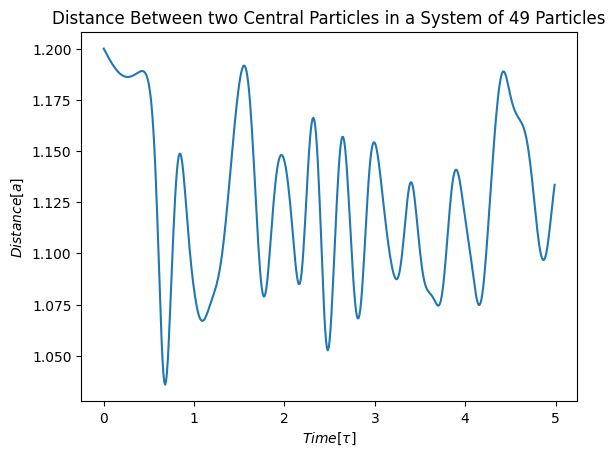

In [ ]:
Np = 49
dt = 0.01
N = t_end/dt

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()

r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)

plt.plot(t,R)
plt.title('Distance Between two Central Particles in a System of 49 Particles')
plt.xlabel("$Time [\\tau]$")
plt.ylabel("$Distance [a]$")
plt.savefig("fourtynine.png")

MovieWriter ffmpeg unavailable; using Pillow instead.


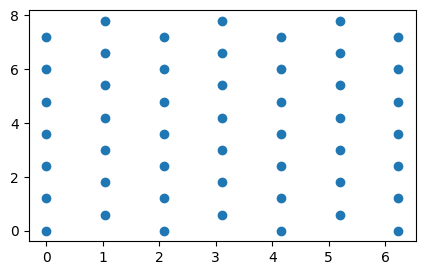

In [ ]:
N = t_end/dt
fig, ax = plt.subplots(figsize=(5, 3))
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,20)
# # ax.vlines((0,10),0,10,'k')
# # ax.hlines((0,10),0,10,'k')
scat = ax.scatter(r[0,:,0] , r[0,:,1])

def animate(i):
    scat.set_offsets(np.c_[r[i*10,:,0],r[i*10,:,1]])

anim = FuncAnimation(fig, animate, interval =60, frames=int(N/10), repeat = True)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('fourtynine.gif')

Above plots show the time evolution of systems with N = 16, 25, and 49 particles aranged in a hexagon structure. As expected a system of so many bodies becomes chaotic very fast. Ploting distance between any two particles will show distorted oscillations, where the distortion comes form all the neighbouring particles. The animation of the entire structure can bee seen in the gif: [animation:49](fourtynine.gif). We see however that even though the displacement of the particle is irregular (with other words not a regular sinusoid wave) it still represents an oscilation around an axis. 

### c.

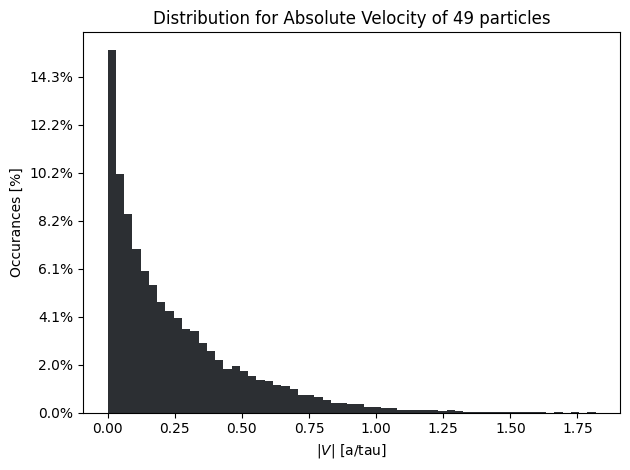

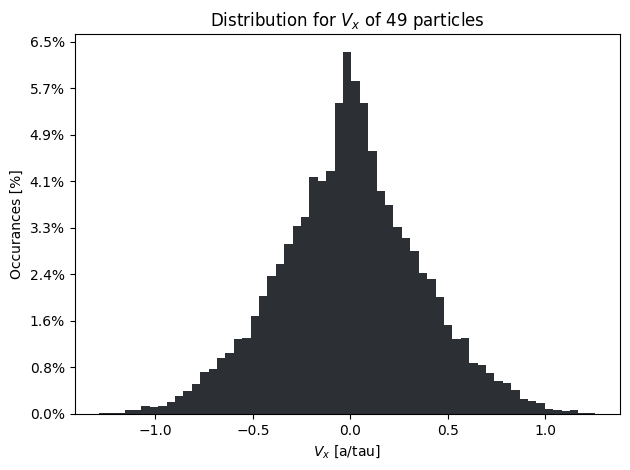

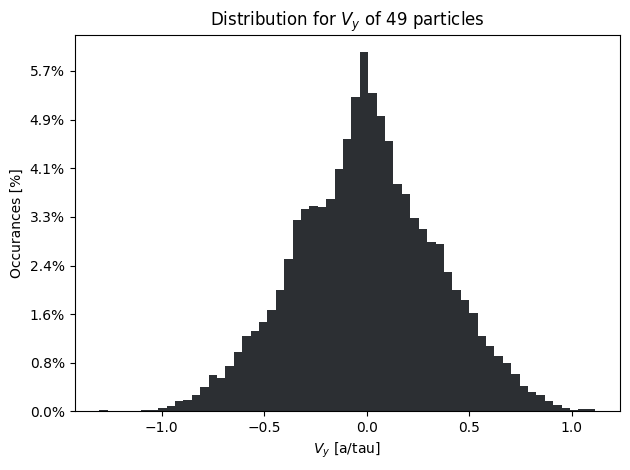

<IPython.core.display.Latex object>

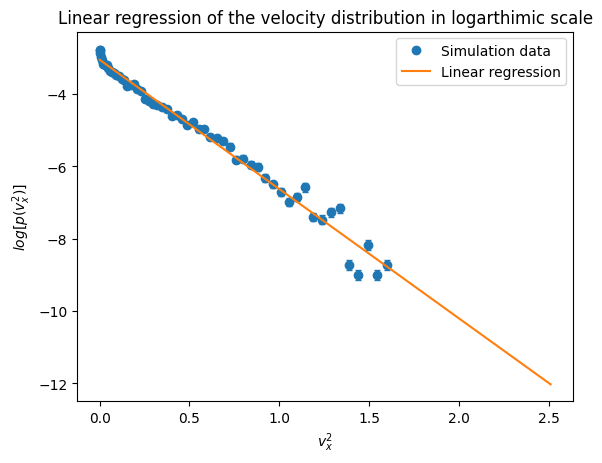

In [ ]:
#Setting up histograms and bar/scatterplots
N = t_end/dt
M = int(round((N*Np)**(1/3)*2, 0)+1)  #customary bins using the Rice method 

#Converting lists into numpy arrays
v_copy = v
V_x = v_copy.reshape(int(N*Np),2)[:,0]
V_y = v_copy.reshape(int(N*Np),2)[:,1]
V_abs = V_x**2+V_y**2

#Visualisation Histograms
fig1, (ax2) = plt.subplots(nrows = 1, ncols = 1)
fig2, (ax4) = plt.subplots(nrows = 1, ncols = 1)
fig3, (ax6) = plt.subplots(nrows = 1, ncols = 1)

ax2.hist(V_abs, bins = M, color="#2c2f33")
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_abs)))
ax2.set_title("Distribution for Absolute Velocity of {} particles".format(Np))
ax2.set_xlabel("$|V|$ [a/tau]")
ax2.set_ylabel("Occurances [%]")

ax4.hist(V_x, bins = M, color="#2c2f33")
ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_x)))
ax4.set_title("Distribution for $V_x$ of {} particles".format(Np))
ax4.set_xlabel("$V_x$ [a/tau]")
ax4.set_ylabel("Occurances [%]")

ax6.hist(V_y, bins = M, color="#2c2f33")
ax6.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_y)))
ax6.set_title("Distribution for $V_y$ of {} particles".format(Np))
ax6.set_xlabel("$V_y$ [a/tau]")
ax6.set_ylabel("Occurances [%]")

fig1.tight_layout()
fig1.savefig("v_distribution.png")
fig2.tight_layout()
fig2.savefig("vx_distribution.png")
fig3.tight_layout()
fig3.savefig("vy_distribution.png")
plt.show()

binwidth = np.max(np.abs(V_x))/M

vx_bins = np.zeros(M)
vx_cts = np.zeros(M)

vx_sort = np.sort(V_x)
for idx in range(0,M):
    vx_bins[idx] = idx*binwidth
    for vx in vx_sort:
        if vx_bins[idx-1]<=np.abs(vx) and np.abs(vx)<=vx_bins[idx]: vx_cts[idx]+=1

vx_bins = np.delete(vx_bins, np.where(vx_cts==0))
vx_cts = np.delete(vx_cts, np.where(vx_cts==0))
vx_tot = np.sum(vx_cts)

res = sp.stats.linregress(vx_bins**2, np.log(vx_cts/vx_tot))

linear = lambda vx2,A,b: A + b*vx2

plt.figure()
plt.plot(vx_bins**2,np.log(vx_cts/vx_tot),"o", label = 'Simulation data')
plt.errorbar(vx_bins**2,np.log(vx_cts/vx_tot), yerr=linear(vx_bins**2,res.intercept_stderr,res.stderr), fmt = 'none', capsize=2)
plt.plot(np.linspace(0,np.max(V_x)*2), linear(np.linspace(0,np.max(V_x)*2),res.intercept,res.slope), label = 'Linear regression')
plt.title('Linear regression of the velocity distribution in logarthimic scale')
plt.xlabel('$v_x^2$')
plt.ylabel('$log{[p(v_x^2)]}$')
plt.legend()
k_b = 1
m = 1

from IPython.display import Latex
T= -m/(2*k_b*res.slope)
display(Latex("T = {} $m/k_B$".format(T)))

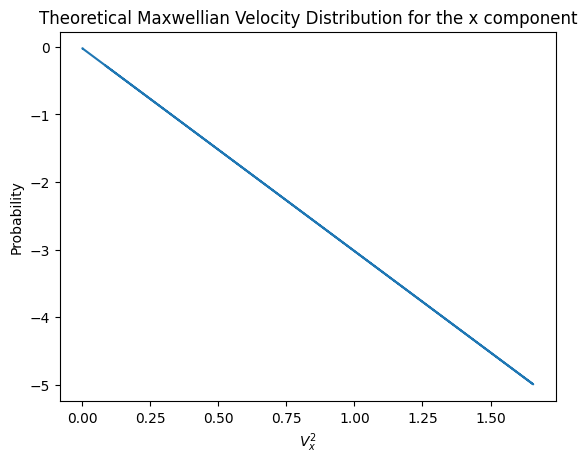

In [ ]:
vx2 = V_x**2
b = 3
A = np.sqrt(b/np.pi)
def p(vx2, A, b):
    return A*np.exp(-b*vx2)
P_vals = p(vx2, A, b)
plt.plot(vx2, np.log(P_vals))
#plt.plot(V_x, P_vals)
plt.title("Theoretical Maxwellian Velocity Distribution for the x component")
plt.xlabel("$V_{x}^{2}$")
plt.ylabel("Probability")
plt.show()

We visualise our velocity calculations by plotting the velocity components and magnitude in seperate histograms. For an ideal ergodic system, the individual particle will be moving in an isotropic fashion. For a system to be considered ergodic requres a large number of particles, meanwhile we analyse for only 49. Even so for such a small sample we notice the histograms are comparable with the theoretical Maxwellian distribution with a peak around 0.

To further analyse the similarity, in the last figure we separate the particles velocities into small intervalls and count the number of times we have a particle with that speed $n_{v_x}$ and the total number of measurements $N_{v_x}$. The probability function is then $p(v_x^2) = \frac{n_{vx}}{N_{v_x}}$. Plotting the the logarithm of $p(v_x)$ we expect a linear relation as according to the Maxwell distribution formula $p = Ae^{-bv_x^2}$ or $log{(p)} = log{(A)} -bv_x^2$ 

We simulate both the systems where particles start with same velocity magnitudes and where only a few in the centre get assigned non-zero velocities. 
The end result is perturbed, and the second case gets more outlying values, but the shape resembles the maxwellian velocity distributions as good as one can expect for $N  \ll \infty $.
We use the number of occurances per histogram "bin" that we bring to linear form by thaking the natural logarithm. Regression analysis reveals the $A$ and $b$ coeffictient that depen on the systems temperature. We use the slope $b$ with dimension [$\mathrm{m}^{2}/\mathrm{s}^{2}$] to obtain the temperature in units of $m/k_{B}$.

MovieWriter ffmpeg unavailable; using Pillow instead.


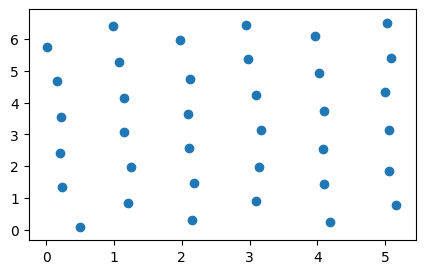

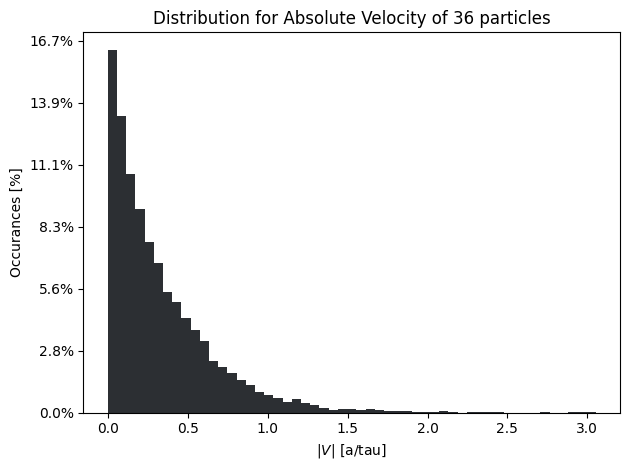

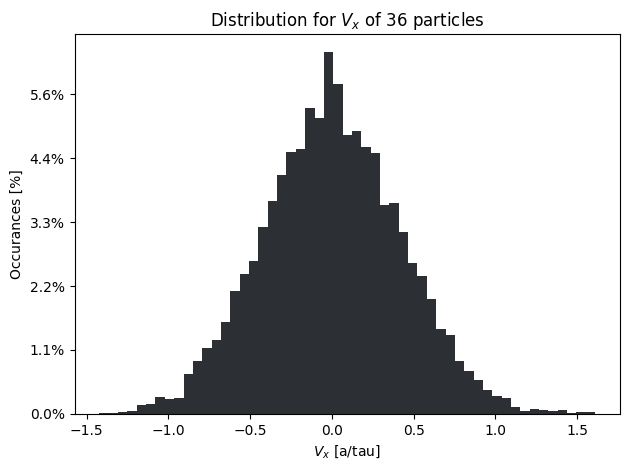

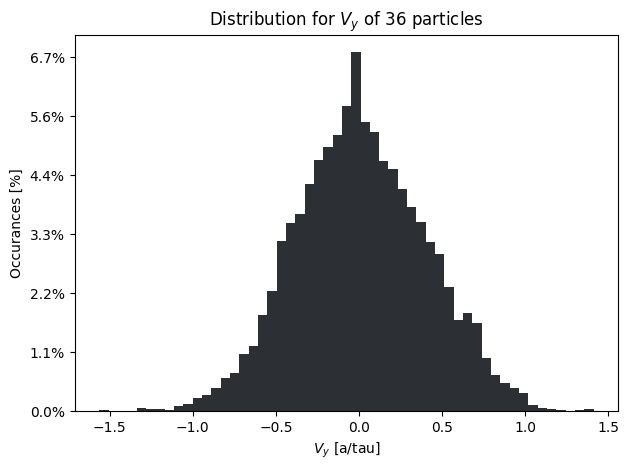

In [ ]:
#System where Np-4 particles have inital v = 0

Np = 36
dt = 0.01
t_end = 5
N = t_end/dt
V0 = 1

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(4))
vel0 = np.zeros((Np,2))
vel0[int(Np/2):int(Np/2)+4,0] += rand
vel0[int(Np/2):int(Np/2)+4,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

r,v,t = integrate(pos0,vel0,t_end,dt,Np)
#R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)

fig, ax = plt.subplots(figsize=(5, 3))
scat = ax.scatter(r[0,:,0] , r[0,:,1])
anim = FuncAnimation(fig, animate, interval =60, frames=int(N/10), repeat = True)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('vel_2.gif')

#Setting up histograms and bar/scatterplots
M = int(round((N*Np)**(1/3)*2, 0)+1)  #customary bins using the Rice method 

#Converting lists into numpy arrays
v_copy = v
V_x = v_copy.reshape(int(N*Np),2)[:,0]
V_y = v_copy.reshape(int(N*Np),2)[:,1]
V_abs = V_x**2+V_y**2

#Visualisation Histograms
fig1, (ax2) = plt.subplots(nrows = 1, ncols = 1)
fig2, (ax4) = plt.subplots(nrows = 1, ncols = 1)
fig3, (ax6) = plt.subplots(nrows = 1, ncols = 1)

ax2.hist(V_abs, bins = M, color="#2c2f33")
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_abs)))
ax2.set_title("Distribution for Absolute Velocity of {} particles".format(Np))
ax2.set_xlabel("$|V|$ [a/tau]")
ax2.set_ylabel("Occurances [%]")

ax4.hist(V_x, bins = M, color="#2c2f33")
ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_x)))
ax4.set_title("Distribution for $V_x$ of {} particles".format(Np))
ax4.set_xlabel("$V_x$ [a/tau]")
ax4.set_ylabel("Occurances [%]")

ax6.hist(V_y, bins = M, color="#2c2f33")
ax6.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(V_y)))
ax6.set_title("Distribution for $V_y$ of {} particles".format(Np))
ax6.set_xlabel("$V_y$ [a/tau]")
ax6.set_ylabel("Occurances [%]")

fig1.tight_layout()
fig1.savefig("v_distribution.png")
fig2.tight_layout()
fig2.savefig("vx_distribution.png")
fig3.tight_layout()
fig3.savefig("vy_distribution.png")
plt.show()

<IPython.core.display.Latex object>

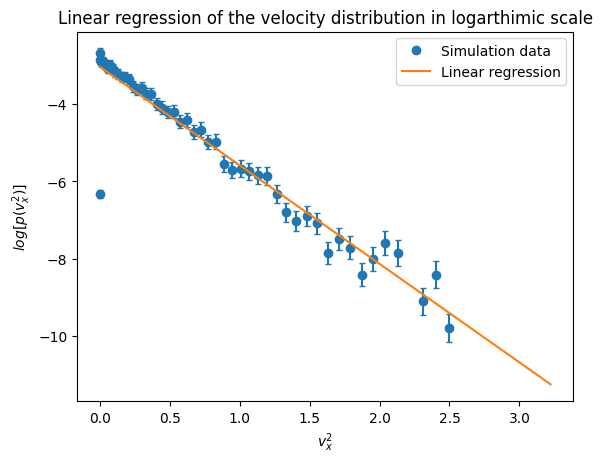

In [ ]:
binwidth = np.max(np.abs(V_x))/M

vx_bins = np.zeros(M)
vx_cts = np.zeros(M)

vx_sort = np.sort(V_x)
for idx in range(0,M):
    vx_bins[idx] = idx*binwidth
    for vx in vx_sort:
        if vx_bins[idx-1]<=np.abs(vx) and np.abs(vx)<=vx_bins[idx]: vx_cts[idx]+=1

vx_bins = np.delete(vx_bins, np.where(vx_cts==0))
vx_cts = np.delete(vx_cts, np.where(vx_cts==0))
vx_tot = np.sum(vx_cts)

res = sp.stats.linregress(vx_bins**2, np.log(vx_cts/vx_tot))

linear = lambda vx2,A,b: A + b*vx2

plt.figure()
plt.plot(vx_bins**2,np.log(vx_cts/vx_tot),"o", label = 'Simulation data')
plt.errorbar(vx_bins**2,np.log(vx_cts/vx_tot), yerr=linear(vx_bins**2,res.intercept_stderr,res.stderr), fmt = 'none', capsize=2)
plt.plot(np.linspace(0,np.max(V_x)*2), linear(np.linspace(0,np.max(V_x)*2),res.intercept,res.slope), label = 'Linear regression')
plt.title('Linear regression of the velocity distribution in logarthimic scale')
plt.xlabel('$v_x^2$')
plt.ylabel('$log{[p(v_x^2)]}$')
plt.legend()

k_b = 1

from IPython.display import Latex
T= -m/(2*k_b*res.slope)
display(Latex("T = {} $m/k_B$".format(T)))

### d.

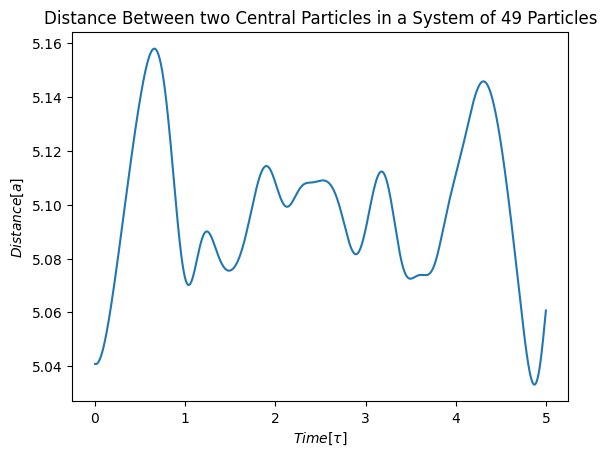

In [ ]:
Np = 36
dt = 0.001
N = t_end/dt
r0 = 1.1*a
V0 = 0.01

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()

r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)

plt.plot(t,R)
plt.title('Distance Between two Central Particles in a System of 49 Particles')
plt.xlabel("$Time [\\tau]$")
plt.ylabel("$Distance [a]$")
plt.savefig("fourtynine.png")

Text(0, 0.5, 'Potential Energy')

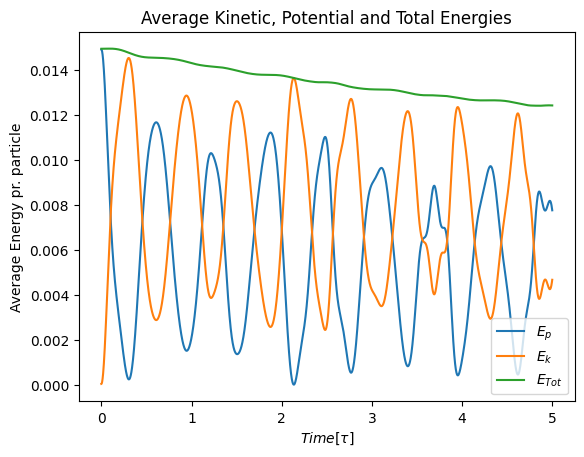

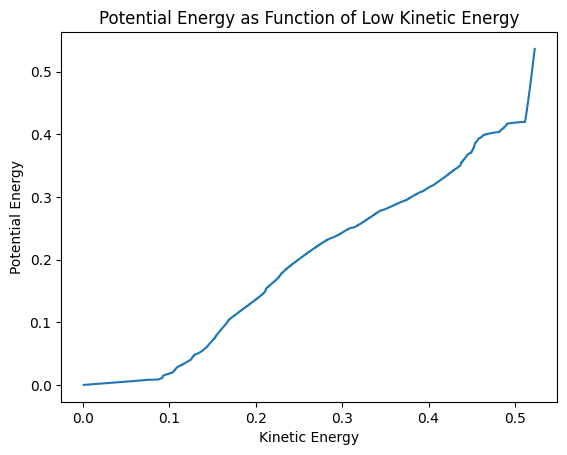

In [ ]:
N = int(N)
E_pot,E_kin,E_tot = energy(r,v,N,Np)

plt.figure('A')
plt.plot(t,E_pot/Np,label = '$E_p$')
plt.plot(t,E_kin/Np, label = '$E_k$')
plt.plot(t,E_tot/Np, label = '$E_{Tot}$')
plt.title('Average Kinetic, Potential and Total Energies')
plt.xlabel("$Time [\\tau]$")                            
plt.ylabel('Average Energy pr. particle')
plt.legend()

plt.figure('B')
plt.plot(np.sort(E_kin),np.sort(E_pot))
plt.title('Potential Energy as Function of Low Kinetic Energy')
plt.xlabel('Kinetic Energy')
plt.ylabel('Potential Energy')

In [ ]:
E_pot_av = np.sum(E_pot)/t[-1]
E_kin_av = np.sum(E_kin)/t[-1]
E_tot_av = np.sum(E_tot)/t[-1]

print("Average values of energies over time ")
print("Potential: {:.5f}".format(E_pot_av))
print("Kinetic: {:.5f}".format(E_kin_av))
print("Total: {:.5f}".format(E_tot_av))

Average values of energies over time 
Potential: 207.78469
Kinetic: 278.45635
Total: 486.24105


**Comment on Problem 2d:**

Above we plot the average values of kinetic, potential and total energies per particle. Then we calculate the potential, kinetic and total energies averaged over time. We see that the average potential and kinetic energies sum up to the total energy as expected. Ploting potential energy as function of the kinetic energy shows direct proportionality. When the kinetic energy goes to zero so does the potential as well. 

### e.

MovieWriter ffmpeg unavailable; using Pillow instead.


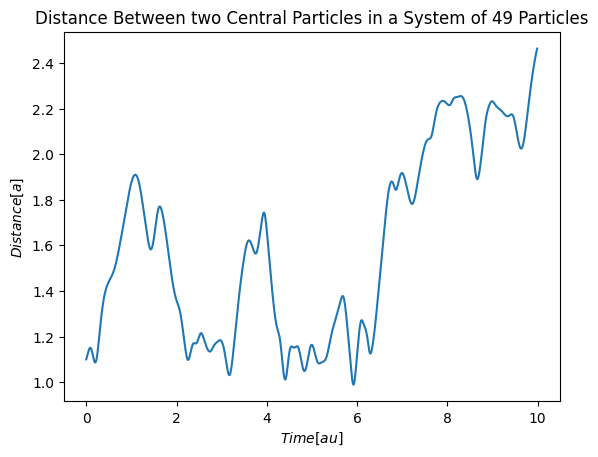

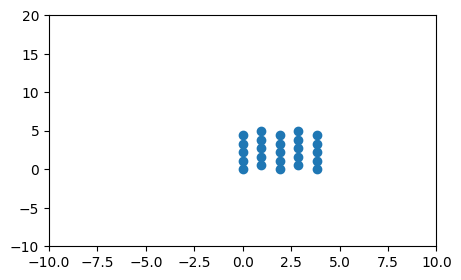

In [ ]:
Np = 25
dt = 0.01
t_end = 10
N = t_end/dt
V0 = 2

pos0 = hexagon(Np, r0)
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()
t = np.arange(0,t_end,dt)
r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)
plt.plot(t,R)
plt.title('Distance Between two Central Particles in a System of 49 Particles')
plt.xlabel("$Time [\tau]$")
plt.ylabel("$Distance [a]$")
plt.savefig("fourtynine.png")

fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlim(-10,10)
ax.set_ylim(-10,20)

scat = ax.scatter(r[0,:,0] , r[0,:,1])

def animate(i):
    scat.set_offsets(np.c_[r[i*10,:,0],r[i*10,:,1]])

anim = FuncAnimation(fig, animate, interval =60, frames=int(N/10), repeat = True)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('liquid.gif')

Above we simulate a system with large initial velocities, supposed to resemble a liquid. Animation showcases the fluid-like moiton of the particles: [animation:liquid](liquid.gif)

In [ ]:
def accelleration(pos0, pos, idx, Np, X = 5, Y = 5):
    f_sum = np.zeros(2)
    for i in range(0, Np):
        if (not idx==i):
            f_sum += lj_force(pos0, pos[i])
            f_sum += 1/np.power(pos0+10,24) - 1/np.power(pos0-10,24)
    return f_sum/m


Np = 25
dt = 0.01
t_end = 5
N = t_end/dt
V0 = 5

pos0 = hexagon(Np, r0)+2
rand = np.random.uniform(0,1,(Np))
vel0 = np.zeros((Np,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(Np,2))
vel0 = vel0 * V0 * direction

plt.figure()
t = np.arange(0,t_end,dt)
r,v,t = integrate(pos0,vel0,t_end,dt,Np)
R = np.linalg.norm(r[:,int(Np/2)-1,:]-r[:,int(Np/2),:],axis=1)

def animate(i):
    scat.set_offsets(np.c_[r[i*10,:,0],r[i*10,:,1]])

anim = FuncAnimation(fig, animate, interval =60, frames=int(N/10), repeat = True)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('gas.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

Above we simulate a system with large initial velocities, supposed to illustratre a gas trapped inside 2D barrier. Animation showcases the gas-like moiton of the particles: [animation:gas](gas.gif)